# Data-Efficient Active Learning (DEAL) example

N2 dissociation on FeCo(110), taken from the supporting data of the DEAL paper. Check the `npj_supporting_data` folder to see the steps to create enhanced sampling trajecory.

## Imports

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

from ase.io import read,write

from deal import DataConfig, DEALConfig, FlareConfig, DEAL
from deal.utils import load_dataframe, compute_histogram


## Load

First execute `get_data.sh` in the input folder. 

In [2]:
!cd input && bash get_data.sh

Trajectory file already present, skipping download.


### Load trajectory

In [3]:
traj_path = 'input/traj-std-ev10.xyz'

traj = read(traj_path,index=':')
len(traj)

3001

### Load COLVAR (optional)

In [4]:
colvar_path = 'input/COLVAR'
colvar = None

if colvar_path is not None:
    try:
        colvar = load_dataframe(colvar_path)

        # save colvar into atoms.info
        for i,atoms in enumerate(traj):
            for col in colvar.columns:
                atoms.info['colvar.'+col] = colvar[col].iloc[i]

    except Exception as e:
        print(e)

colvar

,time,coord_Co-Fe,coord_Co-N,coord_Fe-N,dist_N-N,walker
0,0.0,909.672941,6.840348,8.039158,2.860000,0
1,1.0,911.566457,8.090746,9.031735,3.170941,0
2,2.0,902.426518,7.771793,8.485276,3.252242,0
3,3.0,899.776088,7.600493,8.571635,2.971926,0
4,4.0,901.665373,6.635382,7.309394,1.953947,0
...,...,...,...,...,...,...
2996,2996.0,905.339467,6.936880,7.915974,3.243602,0
2997,2997.0,904.952976,7.049138,8.058686,2.893873,0
2998,2998.0,903.516148,7.353886,8.438719,2.963127,0
2999,2999.0,903.878526,7.598940,8.682715,2.970138,0


## Preprocessing

Pre-select high uncertainty configurations, e.g. via query-by-committee

In [5]:
uncertainty_key = 'force_std_comp_max' # key of array

threshold = 0.09 # None
max_threshold = 3*threshold

if threshold is not None:
    try:
        # define uncertainty of a frame as the max uncertainty on force components
        uncertainty = np.asarray([atoms.get_array(uncertainty_key).max() for atoms in traj])
        # save it in atoms.info
        for i,atoms in enumerate(traj):
            atoms.info['uncertainty'] = uncertainty[i]
            
        preselection = ( uncertainty > threshold ) & ( uncertainty < max_threshold )

        print(f'Preselection by uncertainty: {preselection.sum()}/{len(traj)} frames')

    except Exception as e:
        print('No preselection: uncertainty not found.')
        preselection = np.ones(len(traj),dtype=bool)

Preselection by uncertainty: 1743/3001 frames


Shuffling (reccomended). This can also be done later in the Data Config of DEAL.

In [6]:
# shuffle trajectory
shuffle = True
seed = 42 

# save the original frame no in atoms.info
for i,atoms in enumerate(traj):
    atoms.info['frame'] = i

idx = np.argwhere(preselection)[:,0]
if shuffle:
    np.random.seed(seed)
    np.random.shuffle(idx)
    print('Shuffled')

traj_input = [traj[i] for i in idx]

Shuffled


Write trajectory

In [7]:
deal_input_traj = f'traj-preselection.xyz'
write(f'{deal_input_traj}',traj_input)

/users/sperego/envs/deal/lib/python3.12/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


## DEAL selection 

### Run DEAL from Python (SKIP THIS STEP IF YOU RUN FROM THE COMMAND LINE)
Use the configuration objects (`DataConfig`, `DEALConfig` and `FlareConfig` to specify the settings. 
The COLVAR path is optional; when provided it is passed to the chemiscope writer so CVs appear in the viewer.

#### Choice of the parameters

**Descriptors**

Local environments are characterized via the Atomic Cluster Expansion formalism as implemented in `flare`. Key hyperparameters: body order (`B1/B2`), radial degree `nmax`, angular degree `lmax`, and cutoff (in Å). Set `verbose=True` to see defaults.

**Threshold**

The`threshold` parameter in the DEAL configuration controls when a local environment is flagged by the SGP’s predictive variance (normalized by the noise hyperparameter). If any environment exceeds the threshold, the GP is updated and that environment (plus any others above `update_threshold * threshold`) is added. 

Some tips:

- A good starting point is around 0.1.
- Try a few values and compare how many structures are selected; distributions often are very similar across thresholds, what changes is the number of structures.
- For active learning of ML potentials a possible practical strategy is to pick an initial threshold, run the single-point calculations on the selected structure, update the potential, and then evaluate it on configurations chosen with a tighter threshold to ensure that they are well  described, otherwise expand the training set with them.  

In [9]:
# set DEAL parameters
cutoff = 5
deal_thresholds = [0.05,0.1,0.15]

deal_folder = 'selection'

for deal_threshold in deal_thresholds:
    output_prefix = f'{deal_folder}/deal_{deal_threshold:.3f}'

    data_cfg = DataConfig(
        files=deal_input_traj,
        format='extxyz',
        index=':',
        shuffle=False, # already shuffled
        colvar=None,   # colvar_path colvar info already in atoms.info,
        )

    deal_cfg = DEALConfig(
        threshold=deal_threshold,
        max_atoms_added=0.15,       # fraction of total atoms to add at each iteration 
        initial_atoms=0.2,          # use up to 20% of the atoms of each species for initial training
        output_prefix=output_prefix,
        verbose=True,
    )

    flare_cfg = FlareConfig(cutoff=cutoff)

    deal = DEAL(data_cfg, deal_cfg, flare_cfg)
    # uncomment to run
    # deal.run()

[INFO] Configurations:
- DataConfig(files=['traj-preselection.xyz'],
           format='extxyz',
           index=':',
           colvar=None,
           shuffle=False,
           seed=24)
- DEALConfig(threshold=0.05,
           update_threshold=None,
           max_atoms_added=0.15,
           min_steps_with_model=0,
           initial_atoms=0.2,
           force_only=True,
           train_hyps=False,
           output_prefix='selection/deal_0.050',
           verbose=True,
           save_gp=False,
           debug=False)
- FlareConfig(gp='SGP_Wrapper',
            kernels=[{'name': 'NormalizedDotProduct',
                      'power': 2,
                      'sigma': 2.0}],
            descriptors=[{'cutoff_function': 'cosine',
                          'lmax': 3,
                          'name': 'B2',
                          'nmax': 8,
                          'radial_basis': 'chebyshev'}],
            species=[7, 26, 27],
            cutoff=5,
            variance_type='loc

### CLI equivalent 
The same run can be launched from the command line using the YAML `input.yaml` which will run the three thresholds:

```bash
deal -c input.yaml
```
Consider running it on a HPC cluster or on a high-memory machine: below an example SLURM script to run DEAL on CSCS.
Make sure to adjust the number of nodes, tasks and cpus per task according to your system and the size of your dataset.
See the README for examples of SLURM scripts. 


## Analyze

In [11]:
deal_thresholds = [0.05,0.1,0.15]

traj_deals = {}

print('DEAL Selection')
traj_all = read(f'traj-preselection.xyz',index=':')
for deal_threshold in deal_thresholds:
    try:
        traj = read(f'selection/deal_{deal_threshold}_selected.xyz',index=':')
        traj_deals[deal_threshold] = traj
        print(f'Threshold {deal_threshold:.3f}: {len(traj)}/{len(traj_all)} structures')
    except Exception as e:
        print(e)

colors = mpl.colormaps['fessa'](np.linspace(0, 1, len(traj_deals)))

DEAL Selection
Threshold 0.050: 304/1743 structures
Threshold 0.100: 124/1743 structures
Threshold 0.150: 75/1743 structures


Selection curves

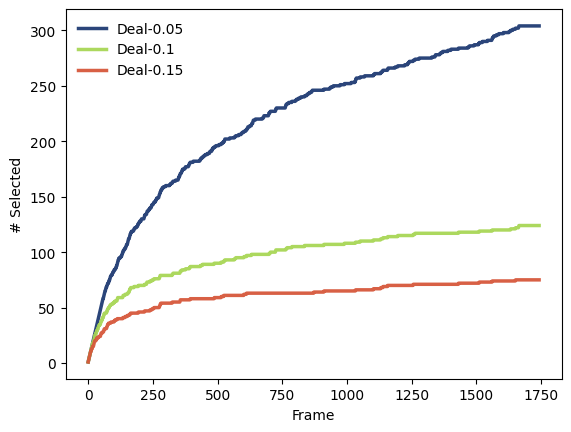

In [12]:
fig, ax = plt.subplots()

for k,(deal_threshold,traj_deal) in enumerate(traj_deals.items()):
    selected_ids = [ atoms.info['step'] for atoms in traj_deal ]
    selection_curve = [np.sum(np.asarray(selected_ids)<=i) for i in range(len(traj_all))]
    ax.plot(selection_curve,label=f'Deal-{deal_threshold}',linewidth=2.5,alpha=0.95, color=colors[k])

ax.set_xlabel('Frame')
ax.set_ylabel('# Selected')
ax.legend(frameon=False)

Histogram vs CVs

Available CVs: ['energy', 'colvar.time', 'colvar.coord_Co-Fe', 'colvar.coord_Co-N', 'colvar.coord_Fe-N', 'colvar.dist_N-N', 'colvar.walker', 'uncertainty', 'frame']


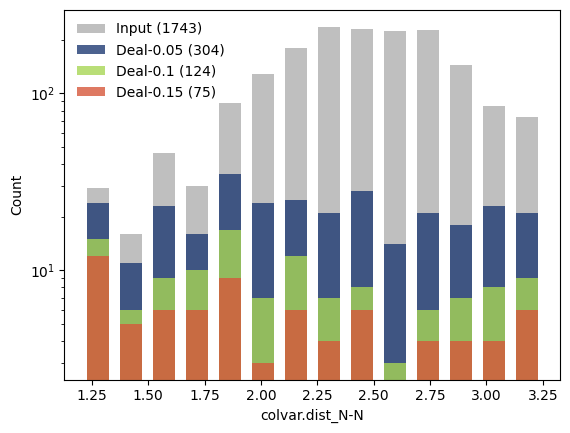

In [13]:
print("Available CVs:",[c for c in traj_all[0].info.keys() ])

cv_name = 'colvar.dist_N-N'

fig, ax = plt.subplots()
cv_all = np.asarray([atoms.info[cv_name] for atoms in traj_all])
bins_cv = np.linspace(cv_all.min(),cv_all.max(),15)
x,h = compute_histogram(cv_all,bins=bins_cv)
ax.bar(x,h,width=(x[1]-x[0])/1.5,label=f'Input ({len(traj_all)})',alpha=0.5,color='grey',zorder=0)
#for xi,hi in zip(x,h):
    #ax.text(xi,hi+5,f'{hi}', horizontalalignment= 'center', color='grey')

for k,(deal_threshold,traj_deal) in enumerate(traj_deals.items()):
    cv_deal = np.asarray([atoms.info[cv_name] for atoms in traj_deal])
    x,h = compute_histogram(cv_deal,bins=bins_cv)
    ax.bar(x,h,width=(x[1]-x[0])/1.5,label=f'Deal-{deal_threshold} ({len(traj_deal)})',alpha=0.8,color=colors[k],zorder=0)
    #for xi,hi in zip(x,h):
        #ax.text(xi-dx/5,hi+5,f'{hi}',color=colors[k])

ax.set_xlabel(cv_name)
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.legend(frameon=False)
plt.show()

In [14]:
import chemiscope
chemiscope.show_input('selection/deal_0.1_chemiscope.json.gz')

<ChemiscopeWidget(meta={'name': 'DEAL selection'}, settings={'structure': [{'atoms': False, 'bonds': False, 's…